# Introduction

The estimated likelihood of a perfect bracket is reported to be around [1 in 120.2 billion](https://www.ncaa.com/news/basketball-men/bracketiq/2021-03-14/perfect-ncaa-bracket-absurd-odds-march-madness-dream). However this analysis underestimates the effect of upsets on the final likelihood. The analysis assumes that the average bracket will pick the correct outcome of a game 2/3rds of the time, which we will see is reasonable accurate. However, not all games in the tournament are made the same, upsets have an outsized impact on the likelihood of a perfect bracket.



# Data




### T-Rank Data

The T-Rank data is pulled the day before the first play-in game.

https://barttorvik.com/timemachine/team_results/20150316_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20160314_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20170313_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20180312_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20190318_team_results.json.gz
https://barttorvik.com/timemachine/team_results/20210317_team_results.json.gz

### Game data
The actual games played were pulled using the game finder on https://barttorvik.com/ filtering for tournament games. 


In [52]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sportsipy.ncaab.schedule import Schedule
from datetime import datetime
from dateutil import parser
from tqdm import tqdm
import math 


# Trank data on the day before the first four game
# Data only extends through 2015 due to tipoff time data limitations
TrankList = ['20150316_team_results.json','20160314_team_results.json',\
             '20170313_team_results.json','20180312_team_results.json','20190318_team_results.json',\
             '20210317_team_results.json']
tourneyGames = ['NCAA2015.csv','NCAA2016.csv',\
               'NCAA2017.csv','NCAA2018.csv','NCAA2019.csv','NCAA2021.csv']
Years = [2015,2016,2017,2018,2019,2021]


In [59]:
# Functions

def convertToOdds(decOdds):
    #https://stackoverflow.com/questions/3154460/python-human-readable-large-numbers
    millnames = ['',' Thousand',' Million',' Billion',' Trillion',' Quadrillion',' Quintillion']

    n = decOdds**-1
    millidx = max(0,min(len(millnames)-1,\
                int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return '{:3.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    
    
def WriteSortedGames(FileList,YearList):

    # This file has the coversions between T-Rank and sports reference
    Translator = pd.read_csv(os.path.join('DATA','Translator.csv'),header=None)

    for ind,(games_file,year) in enumerate(zip(FileList,YearList)):

        print(f' Processing {year}')

        # Empty dataframe with our columns
        df = pd.DataFrame(columns = ['Datetime' , 'Winner', 'Loser'])

        # Read the raw game data
        Games = pd.read_csv(os.path.join('DATA',games_file),header=None)

        # Loop through all relevent games
        for indexs, game in tqdm(Games[4:].iterrows(),total=63): # games 0-3 playin games

            winner= game[1]      
            loser = game[2]

            # Translate team to sports ref
            winner_trans = Translator[Translator[1].str.fullmatch(winner)]        
            winner_ref = winner_trans.iloc[0][0]

            # Convert date to datetime
            datetime_object = datetime.strptime(game[0],  '%m/%d/%Y')

            # Grab schedule data that includes tip times
            schedule = Schedule(winner_ref,year=year)

            matched = False
            for gameref in schedule:
                if gameref.type =='NCAA' and datetime_object==parser.parse(gameref.date):
                    matched= True
                    t = [parser.parse(game[0]+' '+gameref.time),winner,loser]
                    df.loc[len(df)] = t  

            if not matched:
                print(f'{game[0]} , Winner - {winner}, Loser - {loser} - No match??')

        # After all games are added sort by datetime
        df = df.sort_values(by='Datetime', ascending=True)

        # Write to file
        df.to_csv(os.path.join('DATA',f'GamesSorted_{year}.csv'),index=False)
        
    return

In [60]:
# Check if we have sorted the games by datetime, if not do it
gameListSorted = []
for year in Years:
    if os.path.isfile(os.path.join('DATA',f'GamesSorted_{year}.csv')):
        gameListSorted.append(f'GamesSorted_{year}.csv')
    else:
        WriteSortedGames(tourneyGames,Years)
        gameListSorted.append(f'GamesSorted_{year}.csv')


In [63]:
# Initialize arrays
gameOdds = np.zeros((6,64))
coinFlip = np.zeros((64))
twothirdsFlip = np.zeros((64))

# At game zero we are all correct :)
gameOdds[:,0] = 1 
coinFlip[0] = 1
twothirdsFlip[0] = 1

# Loop through all the years
for ind,(trank_file,games_file,year) in enumerate(zip(TrankList,gameListSorted,Years)):
    print(f'\n\n--------------------------------\n      {year} NCAA Tournament\n--------------------------------')
    
    leastLikely = {'Odds':1.0,'Winner':None,'Loser':None}
    mostLikely = {'Odds':0.0,'Winner':None,'Loser':None} 
    upsets = 0
    TRank = pd.read_json(os.path.join('DATA',trank_file), lines=False)
    Games = pd.read_csv(os.path.join('DATA',games_file))

    for indexs, game in Games.iterrows():

        # Get the winner's EM
        winnerEff = TRank[8].loc[TRank[1] == game[1]]
        winnerEff = winnerEff.iat[0]
        
        # Get the loser's EM
        loserEff = TRank[8].loc[TRank[1] == game[2]]
        loserEff = loserEff.iat[0]

        # log5 results
        # http://angrystatistician.blogspot.com/2013/03/baseball-chess-psychology-and.html
        oddsOfOutcome = (winnerEff-winnerEff*loserEff)/(winnerEff+loserEff-2*winnerEff*loserEff) 
        
        if oddsOfOutcome < 0.5:
            upsets += 1
        
        # Update leastLikely
        if leastLikely['Odds'] > oddsOfOutcome:
            leastLikely['Odds'] = oddsOfOutcome
            leastLikely['Winner'] = game[1]
            leastLikely['Loser'] = game[2]
            
        # Update mostLikely   
        if mostLikely['Odds'] < oddsOfOutcome:
            mostLikely['Odds'] = oddsOfOutcome
            mostLikely['Winner'] = game[1]
            mostLikely['Loser'] = game[2]
            
        # add to array
        gameOdds[ind,indexs+1] = oddsOfOutcome
          
        if ind == 0:
            coinFlip[indexs+1] = 0.5 
            twothirdsFlip[indexs+1] = 2./3.
            
    totalOddsYear = np.cumprod(gameOdds[ind,:])
    
    # Print some stuff to the screen
    print(f"\tLeast Likely Game: {leastLikely['Winner']} over {leastLikely['Loser']} - {leastLikely['Odds']*100:.3f}%")
    print(f"\tMost Likely Game: {mostLikely['Winner']} over {mostLikely['Loser']} - {mostLikely['Odds']*100:.3f}%")
    print(f"\tAverage Probability of Game Outcome: {np.mean(gameOdds[ind,:])*100:.3f}%")
    print(f"\tNumber of Upsets: {upsets}")
 

    print(f"\n\tLikelihood of a Perfect Bracket After:")
    print(f"\t\t First Round\t- 1 in {convertToOdds(totalOddsYear[32])}")
    print(f"\t\t Second Round\t- 1 in {convertToOdds(totalOddsYear[48])}")
    print(f"\t\t Sweet Sixteen\t- 1 in {convertToOdds(totalOddsYear[56])}")
    print(f"\t\t Elite Eight\t- 1 in {convertToOdds(totalOddsYear[60])}")
    print(f"\t\t Final Four\t- 1 in {convertToOdds(totalOddsYear[62])}")
    print(f"\t\t Championship\t- 1 in {convertToOdds(totalOddsYear[63])}")
    print(totalOddsYear[63])
# find the cumulative products
totalOdds = np.cumprod(gameOdds,1)
coinFlipOdds = np.cumprod(coinFlip)
twothirdsFlipOdds = np.cumprod(twothirdsFlip)



--------------------------------
      2015 NCAA Tournament
--------------------------------
	Least Likely Game: UAB over Iowa St. - 10.138%
	Most Likely Game: Kentucky over Hampton - 99.411%
	Average Probability of Game Outcome: 68.071%
	Number of Upsets: 13

	Likelihood of a Perfect Bracket After:
		 First Round	- 1 in   1 Million
		 Second Round	- 1 in   4 Billion
		 Sweet Sixteen	- 1 in 106 Billion
		 Elite Eight	- 1 in 771 Billion
		 Final Four	- 1 in   3 Trillion
		 Championship	- 1 in   6 Trillion
1.6098666101315024e-13


--------------------------------
      2016 NCAA Tournament
--------------------------------
	Least Likely Game: Middle Tennessee over Michigan St. - 6.566%
	Most Likely Game: Kansas over Austin Peay - 98.288%
	Average Probability of Game Outcome: 63.554%
	Number of Upsets: 16

	Likelihood of a Perfect Bracket After:
		 First Round	- 1 in  63 Million
		 Second Round	- 1 in 111 Billion
		 Sweet Sixteen	- 1 in  11 Trillion
		 Elite Eight	- 1 in 258 Trillion
		 

C:\Users\Kevin Porter\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


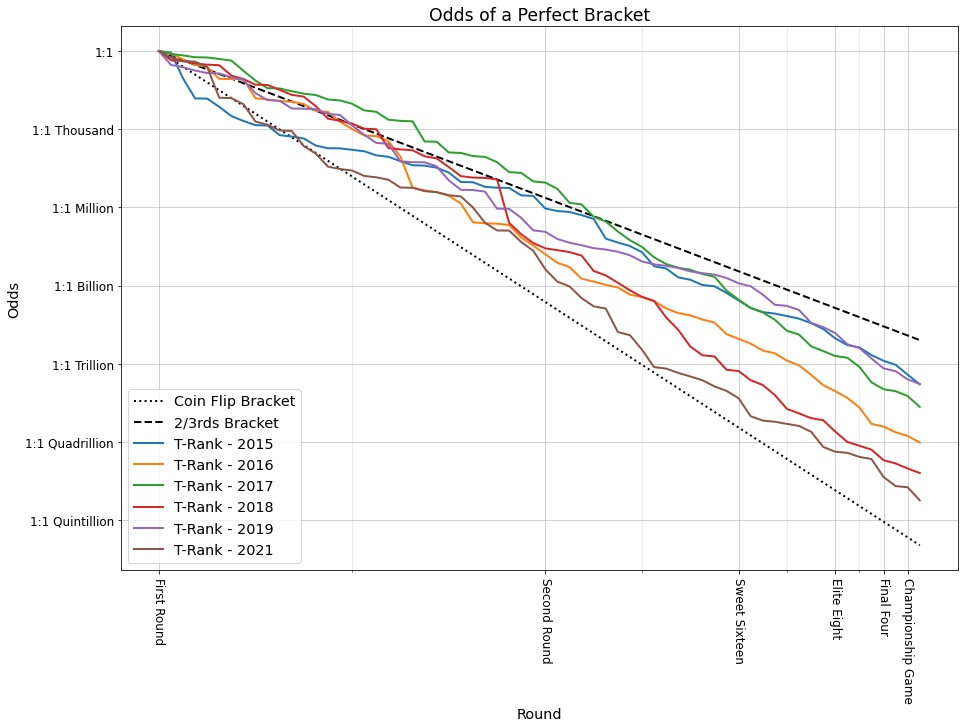

In [62]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(coinFlipOdds, color='black', lw=2,linestyle='dotted',label='Coin Flip Bracket')
line, = ax.plot(twothirdsFlipOdds, color='black', lw=2,linestyle='dashed',label='2/3rds Bracket')
for ind,year in enumerate(Years):
    ax.plot(totalOdds[ind,:],  lw=2,label=f'T-Rank - {year}')


ax.set_yscale('log', base=10)
plt.legend(loc='lower left')
plt.xlabel('Round')
plt.ylabel('Odds')
plt.title('Odds of a Perfect Bracket')

# Set all the stuff
ax.set_yticks([10**0,10**-3,10**-6,10**-9,10**-12,10**-15,10**-18])
ax.set_yticklabels(['1:1','1:1 Thousand','1:1 Million','1:1 Billion','1:1 Trillion','1:1 Quadrillion','1:1 Quintillion'])
ax.set_xticklabels(ax.get_xticks(), rotation = -90)
ax.set_xticks([0,32,48,56,60,62])
ax.set_xticks([16,40,52,58], minor = True)
ax.set_xticklabels(['First Round','Second Round','Sweet Sixteen','Elite Eight','Final Four','Championship Game'])
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)


plt.show()

# Conclusion

The likelihood of a perfect bracket varies dramatically year to year, from 1 in 6 Trillion in both 2019 and 2015 to well over 175 Quadrillion in 2021. Almost 30,000 times more likely